### Same Test and Train Data

In [ ]:
model_output_dir = '/work/b0990106x/trl/model_output/1020-1746'
log_path = f'{model_output_dir}/log_training.log'

import re
import matplotlib.pyplot as plt
import ast
import numpy as np

# Function to parse the log file for both EVAL and Original model metrics
def parse_log_file(log_path):
    eval_pattern = re.compile(
        r"EVAL: Cosine_Sim metrics Training Set for iteration (\d+): (.+)"
    )
    original_model_pattern = re.compile(
        r"Original model metrics on training set: (.+)"
    )
    
    data = {"EVAL": {}, "Original": []}

    # Read the log file line by line
    with open(log_path, 'r') as log_file:
        for line in log_file:
            eval_match = eval_pattern.search(line)
            original_match = original_model_pattern.search(line)

            # If it's an EVAL line
            if eval_match:
                iteration = int(eval_match.group(1)) + 1  # Adding 1 to iteration as requested
                metrics_list = eval_match.group(2).strip()

                # Convert the metrics_list string to a Python object (list of dicts)
                metrics_list = ast.literal_eval(metrics_list)

                # Store means and std_devs for this iteration
                means = []
                std_devs = []
                counts = []

                for metrics in metrics_list:
                    mean = metrics['metrics']['mean']
                    std_dev = metrics['metrics']['std_dev']
                    count = len(metrics['metrics']['rewards'])  # Number of rewards is the sample size

                    means.append(mean)
                    std_devs.append(std_dev)
                    counts.append(count)

                # Store mean, std_dev, and count for each iteration
                data["EVAL"][iteration] = {
                    "means": means,
                    "std_devs": std_devs,
                    "counts": counts
                }

            # If it's an Original Model Metrics line
            elif original_match:
                metrics_list = original_match.group(1).strip()

                # Convert the metrics_list string to a Python object (list of dicts)
                metrics_list = ast.literal_eval(metrics_list)

                for metrics in metrics_list:
                    mean = metrics['metrics']['mean']
                    std_dev = metrics['metrics']['std_dev']
                    data["Original"].append((mean, std_dev))

    return data

# Function to calculate the pooled standard deviation
def pooled_std_dev(std_devs, counts):
    # Pooled variance formula
    numerator = sum((counts[i] - 1) * (std_devs[i] ** 2) for i in range(len(std_devs)))
    denominator = sum(counts[i] - 1 for i in range(len(counts)))

    if denominator > 0:
        pooled_variance = numerator / denominator
        return np.sqrt(pooled_variance)
    else:
        return 0  # In case of single value or no variance

# Function to plot iteration vs the average mean and pooled std_dev
def plot_metrics(data):
    plt.figure(figsize=(10, 6))

    # Plot EVAL data (average across all idx)
    iterations = sorted(data["EVAL"].keys())
    avg_means = []
    pooled_std_devs = []
    
    print(f"Total iterations: {len(iterations)}")
    print(f"Total Original Model data: {len(data['Original'])}")

    for iteration in iterations:
        means = data["EVAL"][iteration]["means"]
        std_devs = data["EVAL"][iteration]["std_devs"]
        counts = data["EVAL"][iteration]["counts"]
        
        # Calculate the average mean for the iteration
        avg_mean = sum(means) / len(means)
        avg_means.append(avg_mean)

        # Calculate the pooled standard deviation for the iteration
        pooled_std_dev_value = pooled_std_dev(std_devs, counts)
        pooled_std_devs.append(pooled_std_dev_value)

    # Plot the average means with pooled std_dev as error bars
    plt.errorbar(iterations, avg_means, yerr=pooled_std_devs, fmt='o-', capsize=5, label='Average Mean with Pooled Std Dev')

    # Plot Original Model data (if available)
    if "Original" in data and len(data["Original"]) > 0:
        original_means = [item[0] for item in data["Original"]]
        original_std_devs = [item[1] for item in data["Original"]]
        avg_original_mean = np.mean(original_means)
        pooled_original_std_dev = pooled_std_dev(original_std_devs, [10] * len(original_std_devs))  # Assuming 10 samples per idx

        plt.errorbar([0], [avg_original_mean], yerr=[pooled_original_std_dev], fmt='x', color='r', label='Original Model Average Mean')

    plt.xlabel('Iteration')
    plt.ylabel('Mean')
    plt.title('Iteration vs Average Mean with Pooled Std Dev')
    plt.grid(True)
    plt.legend()
    plt.show()

# Function to plot iteration vs the average mean with max and min as error bars
def plot_metrics_v2(data):
    plt.figure(figsize=(10, 6))

    # Plot EVAL data (average across all idx)
    iterations = sorted(data["EVAL"].keys())
    avg_means = []
    upper_errors = []
    lower_errors = []
    
    print(f"Total iterations: {len(iterations)}")
    print(f"Total Original Model data: {len(data['Original'])}")

    for iteration in iterations:
        means = data["EVAL"][iteration]["means"]
        max_vals = [max(means)]  
        min_vals = [min(means)]  

        # Calculate the average mean for the iteration
        avg_mean = sum(means) / len(means)
        avg_means.append(avg_mean)

        # Calculate the upper and lower error (max - mean) and (mean - min)
        upper_error = max(max_vals) - avg_mean
        lower_error = avg_mean - min(min_vals)

        upper_errors.append(upper_error)
        lower_errors.append(lower_error)

    # Plot the average means with max/min as error bars
    plt.errorbar(iterations, avg_means, yerr=[lower_errors, upper_errors], fmt='o-', capsize=5, label='Average Mean with Max/Min')

    # Plot Original Model data (if available)
    if "Original" in data and len(data["Original"]) > 0:
        original_means = [item[0] for item in data["Original"]]
        original_max_vals = [max(item[0] for item in data["Original"])]  
        original_min_vals = [min(item[0] for item in data["Original"])]  
        avg_original_mean = np.mean(original_means)
        upper_original_error = max(original_max_vals) - avg_original_mean
        lower_original_error = avg_original_mean - min(original_min_vals)

        plt.errorbar([0], [avg_original_mean], yerr=[[lower_original_error], [upper_original_error]], fmt='x', color='r', label='Original Model Max/Min')

    plt.xlabel('Iteration')
    plt.ylabel('Mean')
    plt.title('Iteration vs Average Mean with Max/Min')
    plt.grid(True)
    plt.legend()
    plt.show()

# Parse the log file
data = parse_log_file(log_path)

# Plot the metrics
plot_metrics(data)
plot_metrics_v2(data)


### Separated Train and Test Data

In [ ]:
model_output_dir = '/work/b0990106x/trl/model_output/1019-1246'
log_path = f'{model_output_dir}/log_training.log'

import re
import matplotlib.pyplot as plt
import ast
import numpy as np

# Function to parse the log file for both EVAL and Original model metrics
def parse_log_file(log_path):
    eval_pattern = re.compile(
        r"EVAL: Cosine_Sim metrics (\w+) Set for iteration (\d+): (.+)"
    )
    original_model_pattern = re.compile(
        r"Original model metrics on testing set: (.+)"
    )
    
    data = {"EVAL": {}, "Original": []}

    # Read the log file line by line
    with open(log_path, 'r') as log_file:
        for line in log_file:
            eval_match = eval_pattern.search(line)
            original_match = original_model_pattern.search(line)

            # If it's an EVAL line
            if eval_match:
                data_set = eval_match.group(1)  # Captures the type of data set (Training, Testing, etc.)
                iteration = int(eval_match.group(2)) + 1  # Adding 1 to iteration as requested
                metrics_list = eval_match.group(3).strip()

                # Convert the metrics_list string to a Python object (list of dicts)
                metrics_list = ast.literal_eval(metrics_list)

                # Store means and std_devs for this iteration
                means = []
                std_devs = []
                counts = []

                for metrics in metrics_list:
                    mean = metrics['metrics']['mean']
                    std_dev = metrics['metrics']['std_dev']
                    count = len(metrics['metrics']['rewards'])  # Number of rewards is the sample size

                    means.append(mean)
                    std_devs.append(std_dev)
                    counts.append(count)

                # Store mean, std_dev, and count for each iteration under the specific dataset type
                if data_set not in data["EVAL"]:
                    data["EVAL"][data_set] = {}
                
                data["EVAL"][data_set][iteration] = {
                    "means": means,
                    "std_devs": std_devs,
                    "counts": counts
                }

            # If it's an Original Model Metrics line
            elif original_match:
                metrics_list = original_match.group(1).strip()

                # Convert the metrics_list string to a Python object (list of dicts)
                metrics_list = ast.literal_eval(metrics_list)

                for metrics in metrics_list:
                    mean = metrics['metrics']['mean']
                    std_dev = metrics['metrics']['std_dev']
                    data["Original"].append((mean, std_dev))

    return data

# Function to calculate the pooled standard deviation
def pooled_std_dev(std_devs, counts):
    # Pooled variance formula
    numerator = sum((counts[i] - 1) * (std_devs[i] ** 2) for i in range(len(std_devs)))
    denominator = sum(counts[i] - 1 for i in range(len(counts)))

    if denominator > 0:
        pooled_variance = numerator / denominator
        return np.sqrt(pooled_variance)
    else:
        return 0  # In case of single value or no variance

# Function to plot iteration vs the average mean and pooled std_dev
def plot_metrics(data, dataset_type='Testing'):
    plt.figure(figsize=(10, 6))

    # Plot EVAL data (average across all idx)
    if dataset_type not in data["EVAL"]:
        print(f"No data available for {dataset_type} set.")
        return

    iterations = sorted(data["EVAL"][dataset_type].keys())
    avg_means = []
    pooled_std_devs = []
    
    print(f"Total iterations: {len(iterations)}")
    print(f"Total Original Model data: {len(data['Original'])}")

    for iteration in iterations:
        means = data["EVAL"][dataset_type][iteration]["means"]
        std_devs = data["EVAL"][dataset_type][iteration]["std_devs"]
        counts = data["EVAL"][dataset_type][iteration]["counts"]
        
        # Calculate the average mean for the iteration
        avg_mean = sum(means) / len(means)
        avg_means.append(avg_mean)

        # Calculate the pooled standard deviation for the iteration
        pooled_std_dev_value = pooled_std_dev(std_devs, counts)
        pooled_std_devs.append(pooled_std_dev_value)

    # Plot the average means with pooled std_dev as error bars
    plt.errorbar(iterations, avg_means, yerr=pooled_std_devs, fmt='o-', capsize=5, label=f'{dataset_type} Set Average Mean with Pooled Std Dev')

    # Plot Original Model data (if available)
    if "Original" in data and len(data["Original"]) > 0:
        original_means = [item[0] for item in data["Original"]]
        original_std_devs = [item[1] for item in data["Original"]]
        avg_original_mean = np.mean(original_means)
        pooled_original_std_dev = pooled_std_dev(original_std_devs, [10] * len(original_std_devs))  # Assuming 10 samples per idx

        plt.errorbar([0], [avg_original_mean], yerr=[pooled_original_std_dev], fmt='x', color='r', label='Original Model Average Mean')

    plt.xlabel('Iteration')
    plt.ylabel('Mean')
    plt.title(f'Iteration vs Average Mean with Pooled Std Dev ({dataset_type} Set)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
data = parse_log_file(log_path)
plot_metrics(data, dataset_type='Testing')  # Plot for the Testing set


### DPO Claps & MOS

In [ ]:
import re
import matplotlib.pyplot as plt

# Model output directory and log path
# model_output_dir = '/work/b0990106x/trl/model_output/1020-2012'
# model_output_dir = '/work/b0990106x/trl/model_output/1023-1238'
# model_output_dir = '/work/b0990106x/trl/model_output/1023-1716'
model_output_dir = '/work/b0990106x/trl/model_output/1023-1910'
log_path = f'{model_output_dir}/log_training.log'

# Initialize lists to store the parsed data
iterations = []
cosine_sim_scores = []
mos_scores = []
weighted_avg_scores = []
chosen_rewards_avg = []
rejected_rewards_avg = []
original_mos_score = 0
original_claps_score = 0
original_weighted_avg_score = 0

# Training
# original_mos_pattern = r"Original model average MOS on training set: ([\d.]+)"
# original_claps_pattern = r"Original model average Claps on training set: ([\d.]+)"
# original_weighted_pattern = r"Original model weighted average rewards on training set: ([\d.]+)"

# mos_pattern = r"MOS score on training set for iteration (\d+): ([\d.]+)"
# cosine_sim_pattern = r"Cosine_Sim score on training set for iteration (\d+): ([\d.]+)"
# weighted_avg_pattern = r"weighted average score on training set for iteration (\d+): ([\d.]+)"

# Testing
original_mos_pattern = r"Original Model Test average MOS: ([\d.]+)"
original_claps_pattern = r"Original Model Test average Claps: ([\d.]+)"
original_weighted_pattern = r"Original Model Test weighted average rewards: ([\d.]+)"

mos_pattern = r"MOS score on Testing set for iteration (\d+): ([\d.]+)"
cosine_sim_pattern = r"Cosine_Sim score on Testing set for iteration (\d+): ([\d.]+)"
weighted_avg_pattern = r"weighted average score on Testing set for iteration (\d+): ([\d.]+)"

chosen_pattern = r"Chosen rewards for iteration \d+: \[([\d., ]+)\]"
rejected_pattern = r"Rejected rewards for iteration \d+: \[([\d\.,\s-]+)\]"

# Open the log file for reading
with open(log_path, 'r') as log_file:
    for line in log_file:
        # Check if the line matches the Cosine_Sim score
        cosine_sim_match = re.search(cosine_sim_pattern, line)
        if cosine_sim_match:
            iteration = int(cosine_sim_match.group(1)) + 1
            cosine_sim_score = float(cosine_sim_match.group(2))
            iterations.append(iteration)
            cosine_sim_scores.append(cosine_sim_score)
        
        # Check if the line matches the MOS score
        mos_match = re.search(mos_pattern, line)
        if mos_match:
            mos_score = float(mos_match.group(2)) / 5  # Normalize MOS score
            mos_scores.append(mos_score)

        # Check if the line matches the weighted average score
        weighted_avg_match = re.search(weighted_avg_pattern, line)
        if weighted_avg_match:
            weighted_avg_score = float(weighted_avg_match.group(2))
            weighted_avg_scores.append(weighted_avg_score)

        # Check if the line matches the original MOS score
        original_mos_match = re.search(original_mos_pattern, line)
        if original_mos_match:
            original_mos_score = float(original_mos_match.group(1)) / 5

        # Check if the line matches the original claps score
        original_claps_match = re.search(original_claps_pattern, line)
        if original_claps_match:
            original_claps_score = float(original_claps_match.group(1))

        # Check if the line matches the original weighted average score
        original_weighted_match = re.search(original_weighted_pattern, line)
        if original_weighted_match:
            original_weighted_avg_score = float(original_weighted_match.group(1))

        # Check if the line matches the chosen rewards
        chosen_match = re.search(chosen_pattern, line)
        if chosen_match:
            chosen_rewards_values = [float(x) for x in chosen_match.group(1).split(", ")]
            chosen_rewards_avg.append(sum(chosen_rewards_values) / len(chosen_rewards_values))  # Take average

        # Check if the line matches the rejected rewards
        rejected_match = re.search(rejected_pattern, line)
        if rejected_match:
            rejected_rewards_values = [float(x) for x in rejected_match.group(1).split(", ")]
            rejected_rewards_avg.append(sum(rejected_rewards_values) / len(rejected_rewards_values))  # Take average

# Plot the metrics
plt.figure(figsize=(10, 6))

# Plot with smaller marker sizes
plt.plot(iterations, weighted_avg_scores, label='Weighted Avg Score', marker='^', markersize=4)
plt.plot(iterations, cosine_sim_scores, label='Cosine_Sim Score', marker='o', markersize=4)
plt.plot(iterations, mos_scores, label='MOS Score', marker='s', markersize=4)

# Plot chosen and rejected rewards averages
if len(chosen_rewards_avg) > 0:
    plt.plot(iterations, chosen_rewards_avg, label='Chosen Rewards Avg', marker='D', linestyle='--', markersize=4)
if len(rejected_rewards_avg) > 0:
    plt.plot(iterations, rejected_rewards_avg, label='Rejected Rewards Avg', marker='x', linestyle=':', markersize=4)

# Plot the original scores as points
plt.plot([0], [original_mos_score], label='Original MOS Score', marker='x', markersize=8, color='red')
plt.plot([0], [original_claps_score], label='Original Claps Score', marker='o', markersize=8, color='green')
plt.plot([0], [original_weighted_avg_score], label='Original Weighted Avg Score', marker='^', markersize=8, color='blue')

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics Over Iterations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



### MOS only

In [ ]:
import re
import matplotlib.pyplot as plt

# Model output directory and log path
# model_output_dir = '/work/b0990106x/trl/model_output/1021-1054'
# model_output_dir = '/work/b0990106x/trl/model_output/1021-1454'
# model_output_dir = '/work/b0990106x/trl/model_output/1021-1607'
# model_output_dir = '/work/b0990106x/trl/model_output/1021-2059'
# model_output_dir = '/work/b0990106x/trl/model_output/1022-0016'
# model_output_dir = '/work/b0990106x/trl/model_output/1022-1223'
# model_output_dir = '/work/b0990106x/trl/model_output/1022-1339'
# model_output_dir = '/work/b0990106x/trl/model_output/1022-1913'
# model_output_dir = '/work/b0990106x/trl/model_output/1102-1403'
model_output_dir = '/work/b0990106x/trl/model_output/1102-1805'

log_path = f'{model_output_dir}/log_training.log'

# Initialize lists to store the parsed data
iterations = []
original_mos_score = 0
mos_scores = []
weighted_avg_scores = []
chosen_rewards_avg = []
rejected_rewards_avg = []

# Regular expression patterns to extract the relevant data
mos_pattern = r"MOS score on training set for iteration (\d+): ([\d.]+)"
original_mos_pattern = r"Original model weighted average rewards on training set: (\d.+)"
weighted_avg_pattern = r"weighted average score on training set for iteration (\d+): ([\d.]+)"
chosen_pattern = r"Chosen rewards for iteration \d+: \[([\d., ]+)\]"
rejected_pattern = r"Rejected rewards for iteration \d+: \[([\d., ]+)\]"

# Open the log file for reading
with open(log_path, 'r') as log_file:  # Replace with your log file path
    for line in log_file:
        
        # Check if the line matches the MOS score
        mos_match = re.search(mos_pattern, line)
        original_mos_match = re.search(original_mos_pattern, line)
        
        if mos_match:
            mos_score = float(mos_match.group(2)) / 5  # Normalize MOS score
            mos_scores.append(mos_score)
        
        if original_mos_match:
            original_mos_score = float(original_mos_match.group(1))
            
        # Check if the line matches the weighted average score
        weighted_avg_match = re.search(weighted_avg_pattern, line)
        if weighted_avg_match:
            weighted_avg_score = float(weighted_avg_match.group(2))
            weighted_avg_scores.append(weighted_avg_score)
        
        # Check if the line matches the chosen rewards
        chosen_match = re.search(chosen_pattern, line)
        if chosen_match:
            chosen_rewards_values = [float(x) for x in chosen_match.group(1).split(", ")]
            chosen_rewards_avg.append(sum(chosen_rewards_values) / len(chosen_rewards_values))  # Take average

        # Check if the line matches the rejected rewards
        rejected_match = re.search(rejected_pattern, line)
        if rejected_match:
            rejected_rewards_values = [float(x) for x in rejected_match.group(1).split(", ")]
            rejected_rewards_avg.append(sum(rejected_rewards_values) / len(rejected_rewards_values))  # Take average

# Ensure all lists have the same length and sorted by iteration
iterations = range(1, len(mos_scores) + 1)

# Plot the metrics
plt.figure(figsize=(10, 6))

# Plot MOS Score and weighted average score
plt.plot(iterations, weighted_avg_scores, label='Weighted Avg Score', marker='^', markersize=4)
plt.plot([0], [original_mos_score], label='Original MOS Score', marker='x', markersize=8)

# Plot average chosen and rejected rewards
if len(chosen_rewards_avg) > 0:
    plt.plot(iterations, chosen_rewards_avg, label='Avg Chosen Rewards', marker='o', linestyle='--', markersize=4)
if len(rejected_rewards_avg) > 0:
    plt.plot(iterations, rejected_rewards_avg, label='Avg Rejected Rewards', marker='s', linestyle=':', markersize=4)

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics Over Iterations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



Original MOS Score: 0.2258203125
Total Iterations Parsed: 80
MOS Scores (Average per Iteration): [0.9208984375, 0.9052734375, 0.850341796875, 0.905029296875, 0.88798828125, 0.98310546875, 1.015966796875, 1.05791015625, 1.013525390625, 1.004443359375, 0.966748046875, 0.932421875, 0.90146484375, 0.94306640625, 0.9439453125, 0.8867431640625, 0.98876953125, 1.108642578125, 0.958447265625, 1.085693359375, 1.0423828125, 0.997265625, 1.01845703125, 0.985888671875, 1.049658203125, 0.9962890625, 0.971533203125, 0.970458984375, 1.00478515625, 1.04580078125, 1.034716796875, 1.070947265625, 1.043310546875, 1.004248046875, 0.977490234375, 1.037841796875, 1.0353515625, 1.07900390625, 1.037060546875, 0.999169921875, 1.195751953125, 1.0142578125, 1.0021484375, 0.9845703125, 0.988427734375, 1.01708984375, 1.1970703125, 1.021435546875, 1.13291015625, 1.0083984375, 1.036572265625, 1.18330078125, 1.11611328125, 1.189453125, 1.13818359375, 1.19501953125, 1.16884765625, 0.966015625, 1.05693359375, 1.0473632

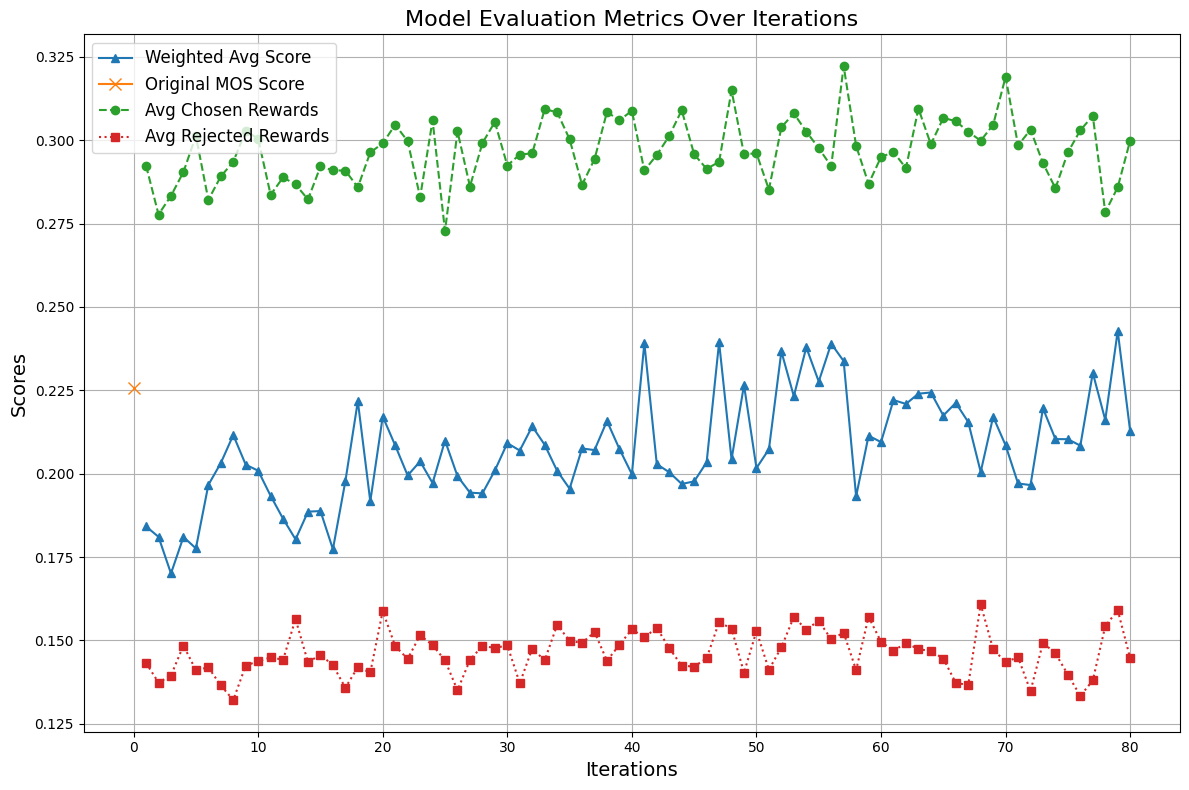

In [2]:
import re
import matplotlib.pyplot as plt

# Model output directory and log path
# model_output_dir = '/work/b0990106x/trl/model_output/1102-1919'
# model_output_dir = '/work/b0990106x/trl/model_output/1103-0030'
# model_output_dir = '/work/b0990106x/trl/model_output/1103-0954'
# model_output_dir = '/work/b0990106x/trl/model_output/1103-1937'
model_output_dir = '/work/b0990106x/trl/model_output/1103-2012'
log_path = f'{model_output_dir}/log_training.log'

# Initialize lists to store the parsed data
original_mos_score = 0
mos_scores = []
weighted_avg_scores = []
chosen_rewards_avg = []
rejected_rewards_avg = []

# Regular expression patterns to extract the relevant data
mos_pattern = r"EVAL: MOS score Training Set for iteration (\d+): \[\[([\d., ]+)\]\]"
weighted_avg_pattern = r"EVAL: Trained model weighted average rewards on training set for iteration (\d+): ([\d.]+)"
original_mos_pattern = r"Original model weighted average rewards on training set: ([\d.]+)"
chosen_pattern = r"Chosen rewards for iteration \d+: \[([\d., ]+)\]"
rejected_pattern = r"Rejected rewards for iteration \d+: \[([\d., ]+)\]"

# Open the log file for reading
with open(log_path, 'r') as log_file:
    for line in log_file:
        # Check if the line matches the Original MOS score
        original_mos_match = re.search(original_mos_pattern, line)
        if original_mos_match:
            original_mos_score = float(original_mos_match.group(1))

        # Check if the line matches the MOS score
        mos_match = re.search(mos_pattern, line)
        if mos_match:
            iteration = int(mos_match.group(1))
            mos_score_list_str = mos_match.group(2)
            mos_score_values = [float(x.strip()) for x in mos_score_list_str.split(",")]
            mos_avg = sum(mos_score_values) / len(mos_score_values)
            mos_scores.append(mos_avg)

        # Check if the line matches the weighted average score
        weighted_avg_match = re.search(weighted_avg_pattern, line)
        if weighted_avg_match:
            iteration = int(weighted_avg_match.group(1))
            weighted_avg_score = float(weighted_avg_match.group(2))
            weighted_avg_scores.append(weighted_avg_score)

        # Check if the line matches the chosen rewards
        chosen_match = re.search(chosen_pattern, line)
        if chosen_match:
            chosen_rewards_values = [float(x.strip()) for x in chosen_match.group(1).split(",")]
            if chosen_rewards_values:
                chosen_avg = sum(chosen_rewards_values) / len(chosen_rewards_values)
                chosen_rewards_avg.append(chosen_avg)

        # Check if the line matches the rejected rewards
        rejected_match = re.search(rejected_pattern, line)
        if rejected_match:
            rejected_rewards_values = [float(x.strip()) for x in rejected_match.group(1).split(",")]
            if rejected_rewards_values:
                rejected_avg = sum(rejected_rewards_values) / len(rejected_rewards_values)
                rejected_rewards_avg.append(rejected_avg)

# Debugging: Print lengths of all lists
print(f"Original MOS Score: {original_mos_score}")
print(f"Total Iterations Parsed: {len(mos_scores)}")
print(f"MOS Scores (Average per Iteration): {mos_scores}")
print(f"Weighted Avg Scores: {weighted_avg_scores}")
print(f"Chosen Rewards Avg: {chosen_rewards_avg}")
print(f"Rejected Rewards Avg: {rejected_rewards_avg}")

# Define iterations based on the maximum length among all metrics
max_length = max(len(mos_scores), len(weighted_avg_scores), len(chosen_rewards_avg), len(rejected_rewards_avg))
iterations = range(1, max_length + 1)

# Plot the metrics
plt.figure(figsize=(12, 8))

# Plot MOS Score and weighted average score
if len(weighted_avg_scores) > 0:
    plt.plot(range(1, len(weighted_avg_scores) + 1), weighted_avg_scores, label='Weighted Avg Score', marker='^', markersize=6)
# if original_mos_score > 0:
#     plt.axhline(y=original_mos_score, color='r', linestyle='-', label='Original MOS Score')
plt.plot([0], [original_mos_score], label='Original MOS Score', marker='x', markersize=8)


# Plot average chosen and rejected rewards
if len(chosen_rewards_avg) > 0:
    plt.plot(range(1, len(chosen_rewards_avg) + 1), chosen_rewards_avg, label='Avg Chosen Rewards', marker='o', linestyle='--', markersize=6)
if len(rejected_rewards_avg) > 0:
    plt.plot(range(1, len(rejected_rewards_avg) + 1), rejected_rewards_avg, label='Avg Rejected Rewards', marker='s', linestyle=':', markersize=6)

# Add labels and title
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Model Evaluation Metrics Over Iterations', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
